<a href="https://colab.research.google.com/github/lauraosede/Fine-tune-BERT-Model-for-Multi-Class-andMulti-Task-Tweets-Classification/blob/main/Fine_tune_BERT_Model_for_Multi_Class_and_Multi_Task_Tweets_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1

## 1.0.1 - Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install keras tf-models-official pydot graphviz
!pip install emot

     |████████████████████████████████| 2.1MB 10.8MB/s 
     |████████████████████████████████| 901kB 42.7MB/s 
     |████████████████████████████████| 3.3MB 44.4MB/s 
     |████████████████████████████████| 1.1MB 10.9MB/s 
     |████████████████████████████████| 1.2MB 39.1MB/s 
     |████████████████████████████████| 174kB 43.2MB/s 
     |████████████████████████████████| 37.6MB 132kB/s 
     |████████████████████████████████| 358kB 46.6MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 706kB 42.1MB/s 
     |████████████████████████████████| 102kB 10.3MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=1e5f7bbd60bbdeebe8278134472b546d46f1cdfb93264184d98e0edd69fe8fc0
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-cp37-none-any.whl size=22245 sha256=6fec8bbc63ceb3a56256b32e8f0b9274

In [3]:
#essentials
import re 
import os
import csv
import glob 
import string  
import random 
import requests 
import numpy as np
import pandas as pd
from datetime import datetime

#preprocessing
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from tqdm.autonotebook import tqdm
import nltk
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import urllib.request
from nltk import pos_tag # For Parts of Speech tagging
from textblob import TextBlob # TextBlob - Python library for processing textual data
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, words # get stopwords from NLTK library & get all words in english language
from nltk.tokenize import word_tokenize # to create word tokens
from nltk.stem import WordNetLemmatizer # to reduce words to orginal form
from emot.emo_unicode import UNICODE_EMO, EMOTICONS # For emojis

def extract_emojis(s):
  return ''.join(c for c in s if c in emoji.UNICODE_EMOJI)

#ploting
import seaborn as sns
import matplotlib.pyplot as plt

#model
from sklearn.model_selection import StratifiedKFold

#evaluation
from sklearn.metrics import precision_score, recall_score, f1_score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  app.launch_new_instance()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [4]:
#Importing transformer modules
import transformers
from scipy.special import softmax
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import BertTokenizer, BertModel, BertConfig,  BertForPreTraining
# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

## 1.0.2 - Functions

In [5]:
#function reads two txt files, converts it to dataframe and returns dataframe
def read_file(filename1, filename2): 
    train_line = []
    train_label = []

    #opening text file
    with open(filename1, 'r') as reader:
        lines = reader.readlines()
        for line in lines:
            train_line.append(line.rstrip())
    
    #opening train file 
    with open(filename2, 'r') as reader:
      label_lines = reader.readlines()
      for line in label_lines:
        train_label.append(line.rstrip())
    

    #convert text file to data frame
    df = pd.DataFrame()
    df['text'] = train_line
    df['Mapping'] = train_label
    return df


In [6]:
#function removes '@',  http links, punctuations, emojis, and stop words from data
def preprocess(tweet): 
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
   
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#|\d+', '', tweet)

    # Remove punctuations
    tweet = re.sub('[%s]' % re.escape(string.punctuation),'',tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)

    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)

    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)  

    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet) 

    #reduce tweet to lowercase 
    tweet = tweet.lower()  

    #convert string to tokens
    PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    tokens = tokenizer.tokenize(tweet) 

    # Remove stopwords
    filtered_words = [w for w in tokens if w not in stop_words]
    filtered_words = [w for w in filtered_words if w not in emojis]
    filtered_words = [w for w in filtered_words if w in word_list]
  
    return tweet
    # Remove punctuations
    unpunctuated_words = [char for char in filtered_words if char not in string.punctuation]
    unpunctuated_words = ' '.join(unpunctuated_words)

    return "".join(unpunctuated_words)  # join words with a space in between them




In [7]:
# function to return words to their base form using Lemmatizer
def preprocessTweetsSentiments(tweet):
    tweet_tokens = word_tokenize(tweet)
    lemmatizer = WordNetLemmatizer() # instatiate an object WordNetLemmatizer Class
    lemma_words = [lemmatizer.lemmatize(w) for w in tweet_tokens]
    return " ".join(lemma_words)

    


In [8]:
# function to obtain adjectives from tweets
def getAdjectives(tweet):
    tweet = word_tokenize(tweet)  # convert string to tokens
    tweet = [word for (word, tag) in pos_tag(tweet)
             if tag == "JJ"]  # pos_tag module in NLTK library
    return " ".join(tweet)  # join words with a space in between them

In [9]:
# Defining my NLTK stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase)
stop_words = stop_words + alphabets
word_list = words.words()  # all words in English language
emojis = list(UNICODE_EMO.keys())  # full list of emojis

## 1.0.3 - Datasets

We will now load the data from a Google Drive directory. The data is already split into train, test and validation sets, so we will be loading the each of these into our file. 

### Emotions dataset (Train and test)

In [52]:
emotion_train = read_file('/content/drive/MyDrive/datasets/emotions/train_text.txt', '/content/drive/MyDrive/datasets/emotions/train_labels.txt')

In [53]:
emotion_test = read_file('/content/drive/MyDrive/datasets/emotions/test_text.txt','/content/drive/MyDrive/datasets/emotions/test_labels.txt')

In [54]:
emotion_train.head()

,text,Mapping
0,“Worry is a down payment on a problem you may ...,2
1,My roommate: it's okay that we can't spell bec...,0
2,No but that's so cute. Atsu was probably shy a...,1
3,Rooneys fucking untouchable isn't he? Been fuc...,0
4,it's pretty depressing when u hit pan on ur fa...,3


In [55]:
emotion_test.head()

,text,Mapping
0,#Deppression is real. Partners w/ #depressed p...,3
1,@user Interesting choice of words... Are you c...,0
2,My visit to hospital for care triggered #traum...,3
3,@user Welcome to #MPSVT! We are delighted to h...,1
4,What makes you feel #joyful?,1


In [ ]:
print("Training Set Shape :", emotion_train.shape)
print("Test Set Shape :", emotion_test.shape)
print("Validation Set Shape :", emotion_val.shape)


Training Set Shape : (3257, 2)
Test Set Shape : (1421, 2)
Validation Set Shape : (374, 2)


In [ ]:
emotion_train.describe()

,text,Mapping
count,3257,3257
unique,3232,4
top,Watch this amazing live.ly broadcast by @user ...,0
freq,15,1400


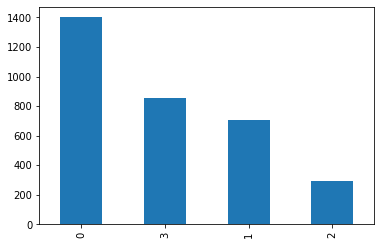

In [ ]:
#Distribution of classes
emotion_train['Mapping'].value_counts().plot(kind = 'bar')

### 1.3.2 - Sentiment dataset (Train and test)

In [ ]:
sentiment_train = read_file('/content/drive/MyDrive/datasets/sentiment/train_text.txt', '/content/drive/MyDrive/datasets/sentiment/train_labels.txt')

In [ ]:
sentiment_test = read_file('/content/drive/MyDrive/datasets/sentiment/test_text.txt','/content/drive/MyDrive/datasets/sentiment/test_labels.txt')

In [ ]:
sentiment_train.head()

,text,Mapping
0,"""QT @user In the original draft of the 7th boo...",2
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,2


In [ ]:
sentiment_test.head()

,text,Mapping
0,@user @user what do these '1/2 naked pics' hav...,1
1,OH: “I had a blue penis while I was this” [pla...,1
2,"@user @user That's coming, but I think the vic...",1
3,I think I may be finally in with the in crowd ...,2
4,"@user Wow,first Hugo Chavez and now Fidel Cast...",0


In [ ]:
print("Training Set Shape :", sentiment_train.shape)
print("Test Set Shape :", sentiment_test.shape)
print("Validation Set Shape :", sentiment_val.shape)


Training Set Shape : (45615, 2)
Test Set Shape : (12284, 2)
Validation Set Shape : (2000, 2)


In [ ]:
sentiment_train.describe()

,text,Mapping
count,45615,45615
unique,45586,3
top,I won the 2nd Star in my McLaren 12C in #CSRRa...,1
freq,3,20673


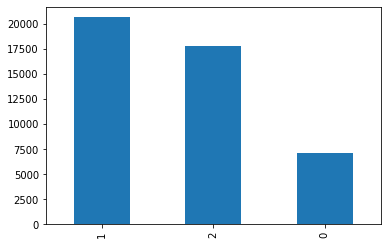

In [ ]:
#Distribution of classes
sentiment_train['Mapping'].value_counts().plot(kind = 'bar')

### Irony dataset

In [ ]:
irony_train = read_file('/content/drive/MyDrive/datasets/irony/train_text.txt', '/content/drive/MyDrive/datasets/irony/train_labels.txt')

In [ ]:
irony_test = read_file('/content/drive/MyDrive/datasets/irony/test_text.txt','/content/drive/MyDrive/datasets/irony/test_labels.txt')

In [ ]:
irony_train.head()

,text,Mapping
0,seeing ppl walking w/ crutches makes me really...,1
1,"look for the girl with the broken smile, ask h...",0
2,Now I remember why I buy books online @user #s...,1
3,@user @user So is he banded from wearing the c...,1
4,Just found out there are Etch A Sketch apps. ...,1


In [ ]:
irony_test.head()

,text,Mapping
0,@user Can U Help?||More conservatives needed o...,0
1,"Just walked in to #Starbucks and asked for a ""...",1
2,#NOT GONNA WIN,0
3,@user He is exactly that sort of person. Weirdo!,0
4,So much #sarcasm at work mate 10/10 #boring 10...,1


In [ ]:
print("Training Set Shape :", irony_train.shape)
print("Test Set Shape :", irony_test.shape)
print("Validation Set Shape :", irony_val.shape)


Training Set Shape : (2862, 2)
Test Set Shape : (784, 2)
Validation Set Shape : (955, 2)


In [ ]:
irony_train.describe()

,text,Mapping
count,2862,2862
unique,2862,2
top,@user only children at home status. Woohoo Isn...,1
freq,1,1445


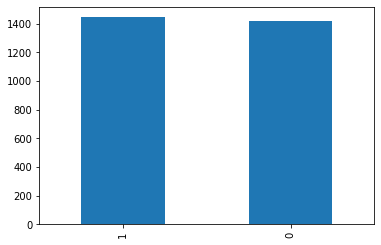

In [ ]:
#Distribution of classes
irony_train['Mapping'].value_counts().plot(kind = 'bar')

# 1.1 Data preprocessing

In this stage, we will;
1.   Creating Meta Features :

*   Word Count
*  Unique word count
*   Mean word length
*   Length of the tweet
*   URL count
*   Hashtag count
*   Mention (@)count
*   stop word count
*   Punctuation count

2.   basic data preprocessing





### 1.1.1 - Emotions dataset

In [ ]:
#word count
emotion_train['word_count'] = emotion_train['text'].apply( lambda x: len(str(x).split()))
emotion_test['word_count'] = emotion_test['text'].apply( lambda x: len(str(x).split()))

#Unique word count
emotion_train['unique_wordcount'] = emotion_train['text'].apply(lambda x: len(set(str(x).split())))
emotion_test['unique_wordcount'] = emotion_test['text'].apply(lambda x: len(set(str(x).split())))

#Mean word length
emotion_train['mean_word_length'] = emotion_train['text'].apply(lambda x: round(np.mean([len(w) for w in str(x).split()]),2))
emotion_test['mean_word_length'] = emotion_test['text'].apply(lambda x: round(np.mean([len(w) for w in str(x).split()]),2))

#length of the tweet
emotion_train['tweet_length'] = emotion_train['text'].apply(lambda x: len(x))
emotion_test['tweet_length'] = emotion_test['text'].apply(lambda x: len(x))

#Url count
emotion_train['url_count'] = emotion_train['text'].apply( lambda x: len(re.findall('https?:\/\/',x)))
emotion_test['url_count'] = emotion_test['text'].apply( lambda x: len(re.findall('https?:\/\/',x)))

#hashtag count
emotion_train['hashtags'] = emotion_train['text'].apply( lambda x: len(re.findall('#.*',x)))
emotion_test['hashtags'] = emotion_test['text'].apply( lambda x: len(re.findall('#.*',x)))

#mention (@)
emotion_train['mention_count'] = emotion_train['text'].apply( lambda x: len(re.findall('@.*',x)))
emotion_test['mention_count'] = emotion_test['text'].apply( lambda x: len(re.findall('@.*',x)))

# stopword count
emotion_train['stopwords'] = emotion_train['text'].apply( lambda x: len([w for w in x.lower().split() if w in STOPWORDS]))
emotion_test['stopwords'] = emotion_test['text'].apply( lambda x: len([w for w in x.lower().split() if w in STOPWORDS]))

#punctuation count
emotion_train['punctuation_count'] = emotion_train['text'].apply( lambda x: len( re.findall('[%s]' %string.punctuation,x)))
emotion_test['punctuation_count'] = emotion_test['text'].apply( lambda x: len( re.findall('[%s]' %string.punctuation,x)))

# Apply getAdjectives function to the new 'Processed Tweets' column to generate a new column called 'Tweets_Adjectives'
emotion_train['text_Adjectives'] = emotion_train['text'].apply(getAdjectives)
emotion_test['text_Adjectives'] = emotion_test['text'].apply(getAdjectives)

#### Basic data preprocessing

Before performing exploratory data analysis, we need to clean and prepare our data as much as possible. Tasks here will include;


1.   Lowercase the tweets 
2.   Removing URL from text
3.   Special characters are removed (first, words attached with special characters are separated
4.   Remove punctuations
5.   Lemmatize tweet - reduces the inflectional forms of each word into a common base or root.
6.   Abbreviations are expanded
7.   Expand contractions
8.   Typos and slangs are corrected
9.   Character entities are replaced with their atual sysmbols
10.   As hashtags and usernames contains important information regarding the context, words are separated from them. Then '#' amd '@' mentions are removed
11.   Removing null values or performing imputation from our dataset













In [ ]:
'''
Apply preprocess function to the 'text' column to generate a new column called 'Processed text'.
This function will;
1. remove urls, 
2. remove @ and #.
3. Remove punctuations 
4. Remove emojis
5. remove stop words
'''
emotion_train['Processed_Text'] = emotion_train['text'].apply(preprocess)
emotion_test['Processed_Text'] = emotion_test['text'].apply(preprocess)

In [ ]:
#printing results for better analysis
print(emotion_train['text'][19])
print(emotion_train['Processed_Text'][19])

@user @user @user Tamra would F her up if she swung on Tamra\nKelly is a piece of 💩 #needstobeadmitted #bully
   tamra would f her up if she swung on tamrankelly is a piece of 💩 needstobeadmitted bully


In [ ]:
emotion_train[['text','Processed_Text']].head()

,text,Processed_Text
0,“Worry is a down payment on a problem you may ...,“worry is a down payment on a problem you may ...
1,My roommate: it's okay that we can't spell bec...,my roommate its okay that we cant spell becaus...
2,No but that's so cute. Atsu was probably shy a...,no but thats so cute atsu was probably shy abo...
3,Rooneys fucking untouchable isn't he? Been fuc...,rooneys fucking untouchable isnt he been fucki...
4,it's pretty depressing when u hit pan on ur fa...,its pretty depressing when u hit pan on ur fav...


In [ ]:
emotion_test[['text','Processed_Text']].head()

,text,Processed_Text
0,#Deppression is real. Partners w/ #depressed p...,deppression is real partners w depressed peopl...
1,@user Interesting choice of words... Are you c...,interesting choice of words are you confirmin...
2,My visit to hospital for care triggered #traum...,my visit to hospital for care triggered trauma...
3,@user Welcome to #MPSVT! We are delighted to h...,welcome to mpsvt we are delighted to have you...
4,What makes you feel #joyful?,what makes you feel joyful


In [ ]:
emotion_train.to_csv('/content/drive/MyDrive/datasets/preprocessedEmotionTrain.csv')

In [ ]:
emotion_test.to_csv('/content/drive/MyDrive/datasets/preprocessedEmotionTest.csv')

### 1.1.2 - Sentiment dataset

In [ ]:
#word count
sentiment_train['word_count'] = sentiment_train['text'].apply( lambda x: len(str(x).split()))
sentiment_test['word_count'] = sentiment_test['text'].apply( lambda x: len(str(x).split()))

#Unique word count
sentiment_train['unique_wordcount'] = sentiment_train['text'].apply(lambda x: len(set(str(x).split())))
sentiment_test['unique_wordcount'] = sentiment_test['text'].apply(lambda x: len(set(str(x).split())))

#Mean word length
sentiment_train['mean_word_length'] = sentiment_train['text'].apply(lambda x: round(np.mean([len(w) for w in str(x).split()]),2))
sentiment_test['mean_word_length'] = sentiment_test['text'].apply(lambda x: round(np.mean([len(w) for w in str(x).split()]),2))

#length of the tweet
sentiment_train['tweet_length'] = sentiment_train['text'].apply(lambda x: len(x))
sentiment_test['tweet_length'] = sentiment_test['text'].apply(lambda x: len(x))

#Url count
sentiment_train['url_count'] = sentiment_train['text'].apply( lambda x: len(re.findall('https?:\/\/',x)))
sentiment_test['url_count'] = sentiment_test['text'].apply( lambda x: len(re.findall('https?:\/\/',x)))

#hashtag count
sentiment_train['hashtags'] = sentiment_train['text'].apply( lambda x: len(re.findall('#.*',x)))
sentiment_test['hashtags'] = sentiment_test['text'].apply( lambda x: len(re.findall('#.*',x)))

#mention (@)
sentiment_train['mention_count'] = sentiment_train['text'].apply( lambda x: len(re.findall('@.*',x)))
sentiment_test['mention_count'] = sentiment_test['text'].apply( lambda x: len(re.findall('@.*',x)))

# stopword count
sentiment_train['stopwords'] = sentiment_train['text'].apply( lambda x: len([w for w in x.lower().split() if w in STOPWORDS]))
sentiment_test['stopwords'] = sentiment_test['text'].apply( lambda x: len([w for w in x.lower().split() if w in STOPWORDS]))

#punctuation count
sentiment_train['punctuation_count'] = sentiment_train['text'].apply( lambda x: len( re.findall('[%s]' %string.punctuation,x)))
sentiment_test['punctuation_count'] = sentiment_test['text'].apply( lambda x: len( re.findall('[%s]' %string.punctuation,x)))

# Apply getAdjectives function to the new 'Processed Tweets' column to generate a new column called 'Tweets_Adjectives'
sentiment_train['text_Adjectives'] = sentiment_train['text'].apply(getAdjectives)
sentiment_test['text_Adjectives'] = sentiment_test['text'].apply(getAdjectives)

#### Basic data preprocessing

Before performing exploratory data analysis, we need to clean and prepare our data as much as possible. Tasks here will include;


1.   Lowercase the tweets 
2.   Removing URL from text
3.   Special characters are removed (first, words attached with special characters are separated
4.   Remove punctuations
5.   Lemmatize tweet - reduces the inflectional forms of each word into a common base or root.
6.   Abbreviations are expanded
7.   Expand contractions
8.   Typos and slangs are corrected
9.   Character entities are replaced with their atual sysmbols
10.   As hashtags and usernames contains important information regarding the context, words are separated from them. Then '#' amd '@' mentions are removed
11.   Removing null values or performing imputation from our dataset













In [ ]:
'''
Apply preprocess function to the 'text' column to generate a new column called 'Processed text'.
This function will;
1. remove urls, 
2. remove @ and #.
3. Remove punctuations 
4. Remove emojis
5. remove stop words
'''
sentiment_train['Processed_Text'] = sentiment_train['text'].apply(preprocess)
sentiment_test['Processed_Text'] = sentiment_test['text'].apply(preprocess)

In [ ]:
#printing results for better analysis
print(sentiment_train['text'][19])
print(sentiment_train['Processed_Text'][19])

What is Jamie Foxx doing sitting next to Niall like you could've sat in a better spot just saying lol
what is jamie foxx doing sitting next to niall like you couldve sat in a better spot just saying lol


In [ ]:
sentiment_train[['text','Processed_Text']].head()

,text,Processed_Text
0,"""QT @user In the original draft of the 7th boo...",qt in the original draft of the th book remus...
1,"""Ben Smith / Smith (concussion) remains out of...",ben smith smith concussion remains out of the...
2,Sorry bout the stream last night I crashed out...,sorry bout the stream last night i crashed out...
3,Chase Headley's RBI double in the 8th inning o...,chase headleys rbi double in the th inning off...
4,@user Alciato: Bee will invest 150 million in ...,alciato bee will invest million in january a...


In [ ]:
sentiment_test[['text','Processed_Text']].head()

,text,Processed_Text
0,@user @user what do these '1/2 naked pics' hav...,what do these naked pics have to do with an...
1,OH: “I had a blue penis while I was this” [pla...,oh “i had a blue penis while i was this” playi...
2,"@user @user That's coming, but I think the vic...",thats coming but i think the victims are goi...
3,I think I may be finally in with the in crowd ...,i think i may be finally in with the in crowd ...
4,"@user Wow,first Hugo Chavez and now Fidel Cast...",wowfirst hugo chavez and now fidel castro dan...


In [ ]:
sentiment_train.to_csv('/content/drive/MyDrive/datasets/preprocessedSentimentTrain.csv')

In [ ]:
sentiment_test.to_csv('/content/drive/MyDrive/datasets/preprocessedSentimentTest.csv')

### 1.1.3 - Irony dataset

In [ ]:
#word count
irony_train['word_count'] = irony_train['text'].apply( lambda x: len(str(x).split()))
irony_test['word_count'] = irony_test['text'].apply( lambda x: len(str(x).split()))

#Unique word count
irony_train['unique_wordcount'] = irony_train['text'].apply(lambda x: len(set(str(x).split())))
irony_test['unique_wordcount'] = irony_test['text'].apply(lambda x: len(set(str(x).split())))

#Mean word length
irony_train['mean_word_length'] = irony_train['text'].apply(lambda x: round(np.mean([len(w) for w in str(x).split()]),2))
irony_test['mean_word_length'] = irony_test['text'].apply(lambda x: round(np.mean([len(w) for w in str(x).split()]),2))

#length of the tweet
irony_train['tweet_length'] = irony_train['text'].apply(lambda x: len(x))
irony_test['tweet_length'] = irony_test['text'].apply(lambda x: len(x))

#Url count
irony_train['url_count'] = irony_train['text'].apply( lambda x: len(re.findall('https?:\/\/',x)))
irony_test['url_count'] = irony_test['text'].apply( lambda x: len(re.findall('https?:\/\/',x)))

#hashtag count
irony_train['hashtags'] = irony_train['text'].apply( lambda x: len(re.findall('#.*',x)))
irony_test['hashtags'] = irony_test['text'].apply( lambda x: len(re.findall('#.*',x)))

#mention (@)
irony_train['mention_count'] = irony_train['text'].apply( lambda x: len(re.findall('@.*',x)))
irony_test['mention_count'] = irony_test['text'].apply( lambda x: len(re.findall('@.*',x)))

# stopword count
irony_train['stopwords'] = irony_train['text'].apply( lambda x: len([w for w in x.lower().split() if w in STOPWORDS]))
irony_test['stopwords'] = irony_test['text'].apply( lambda x: len([w for w in x.lower().split() if w in STOPWORDS]))

#punctuation count
irony_train['punctuation_count'] = irony_train['text'].apply( lambda x: len( re.findall('[%s]' %string.punctuation,x)))
irony_test['punctuation_count'] = irony_test['text'].apply( lambda x: len( re.findall('[%s]' %string.punctuation,x)))

# Apply getAdjectives function to the new 'Processed Tweets' column to generate a new column called 'Tweets_Adjectives'
irony_train['text_Adjectives'] = irony_train['text'].apply(getAdjectives)
irony_test['text_Adjectives'] = irony_test['text'].apply(getAdjectives)

#### Basic data preprocessing

Before performing exploratory data analysis, we need to clean and prepare our data as much as possible. Tasks here will include;


1.   Lowercase the tweets 
2.   Removing URL from text
3.   Special characters are removed (first, words attached with special characters are separated
4.   Remove punctuations
5.   Lemmatize tweet - reduces the inflectional forms of each word into a common base or root.
6.   Abbreviations are expanded
7.   Expand contractions
8.   Typos and slangs are corrected
9.   Character entities are replaced with their atual sysmbols
10.   As hashtags and usernames contains important information regarding the context, words are separated from them. Then '#' amd '@' mentions are removed
11.   Removing null values or performing imputation from our dataset













In [ ]:
'''
Apply preprocess function to the 'text' column to generate a new column called 'Processed text'.
This function will;
1. remove urls, 
2. remove @ and #.
3. Remove punctuations 
4. Remove emojis
5. remove stop words
'''
irony_train['Processed_Text'] = irony_train['text'].apply(preprocess)
irony_test['Processed_Text'] = irony_test['text'].apply(preprocess)

In [ ]:
#printing results for better analysis
print(irony_train['text'][19])
print(irony_train['Processed_Text'][19])

Main issue with the walking dead- you forget to breathe when you're watching. So bloody good #WalkingDead
main issue with the walking dead you forget to breathe when youre watching so bloody good walkingdead


In [ ]:
irony_train[['text','Processed_Text']].head()

,text,Processed_Text
0,seeing ppl walking w/ crutches makes me really...,seeing ppl walking w crutches makes me really ...
1,"look for the girl with the broken smile, ask h...",look for the girl with the broken smile ask he...
2,Now I remember why I buy books online @user #s...,now i remember why i buy books online service...
3,@user @user So is he banded from wearing the c...,so is he banded from wearing the clothes karma
4,Just found out there are Etch A Sketch apps. ...,just found out there are etch a sketch apps o...


In [ ]:
irony_test[['text','Processed_Text']].head()

,text,Processed_Text
0,@user Can U Help?||More conservatives needed o...,can u helpmore conservatives needed on tsu g...
1,"Just walked in to #Starbucks and asked for a ""...",just walked in to starbucks and asked for a ta...
2,#NOT GONNA WIN,not gonna win
3,@user He is exactly that sort of person. Weirdo!,he is exactly that sort of person weirdo
4,So much #sarcasm at work mate 10/10 #boring 10...,so much sarcasm at work mate boring dead mat...


In [ ]:
irony_train.to_csv('/content/drive/MyDrive/datasets/preprocessedIronyTrain.csv')

In [ ]:
irony_test.to_csv('/content/drive/MyDrive/datasets/preprocessedIronyTest.csv')

# 1.2.0 Exploratory data analysis

Creating a simple bar plot to see the distribution of target values for each task

### Emotions

In [ ]:
emotions_train = pd.read_csv('/content/drive/MyDrive/datasets/preprocessedEmotionTrain.csv')

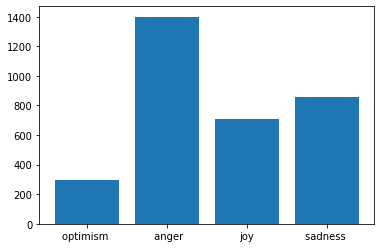

In [ ]:
classes = emotions_train.Mapping.unique()
counts = []

for i in classes:
  count = len(emotions_train[emotions_train.Mapping==i])
  counts.append(count)

plt.bar(['optimism ',	' anger',	'joy',	'sadness '], counts)
plt.show()

In [ ]:
emotions_test = pd.read_csv('/content/drive/MyDrive/datasets/preprocessedEmotionTest.csv')

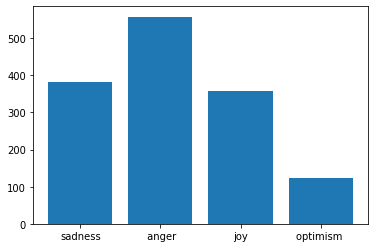

In [ ]:
classes = emotions_test.Mapping.unique()
counts = []

for i in classes:
  count = len(emotions_test[emotions_test.Mapping==i])
  counts.append(count)

plt.bar(['sadness',	' anger',	'joy',	'optimism '], counts)
plt.show()

The emotions train and test dataset is heavily skewed, to deal with this, we will have to stratify our train and test set when training our model.

### Sentiment

In [ ]:
sentiment_train = pd.read_csv('/content/drive/MyDrive/datasets/preprocessedSentimentTrain.csv')

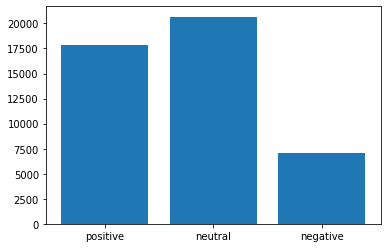

In [ ]:
classes = sentiment_train.Mapping.unique()
counts = []

for i in classes:
  count = len(sentiment_train[sentiment_train.Mapping==i])
  counts.append(count)

plt.bar(['positive', 'neutral',  'negative'], counts)
plt.show()

In [ ]:
sentiment_test = pd.read_csv('/content/drive/MyDrive/datasets/preprocessedSentimentTest.csv')

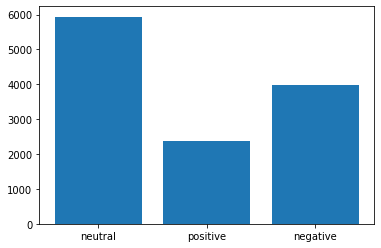

In [ ]:
classes = sentiment_test.Mapping.unique()
counts = []

for i in classes:
  count = len(sentiment_test[sentiment_test.Mapping==i])
  counts.append(count)

plt.bar(['neutral', 'positive',  'negative'], counts)
plt.show()

The sentiment train and test dataset is heavily skewed, to deal with this, we will have to stratify our train and test set when training our model.

### Irony 

In [ ]:
irony_train = pd.read_csv('/content/drive/MyDrive/datasets/preprocessedIronyTrain.csv')

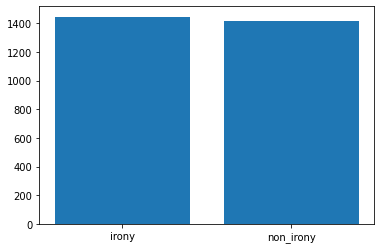

In [ ]:
classes = irony_train.Mapping.unique()
counts = []

for i in classes:
  count = len(irony_train[irony_train.Mapping==i])
  counts.append(count)

plt.bar(['irony', 'non_irony'], counts)
plt.show()


In [ ]:
irony_test = pd.read_csv('/content/drive/MyDrive/datasets/preprocessedIronyTest.csv')

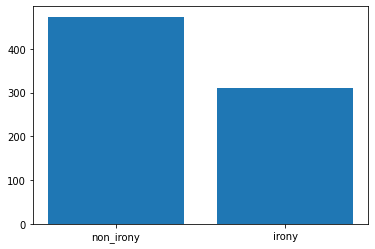

In [ ]:
classes = irony_test.Mapping.unique()
counts = []

for i in classes:
  count = len(irony_test[irony_test.Mapping==i])
  counts.append(count)

plt.bar(['non_irony', 'irony'], counts)
plt.show()

The irony test dataset is  skewed, to deal with this, we will have to stratify our train and test set when training our model.

Creating word cloud to vizualize the most used words in each dataset

### Sentiment

In [ ]:
neutral_df = sentiment_train.loc[sentiment_train['Mapping']==1]['Processed_Text'] #joy tweets 
neutral_df = neutral_df.apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS])) # removing stopwords

In [ ]:
positive_df = sentiment_train.loc[sentiment_train['Mapping']==2]['Processed_Text'] #joy tweets 
positive_df = positive_df.apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS])) # removing stopwords

In [ ]:
negative_df = sentiment_train.loc[sentiment_train['Mapping']==0]['Processed_Text'] #joy tweets 
negative_df = negative_df.apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS])) # removing stopwords

Text(0.5, 1.0, 'Neutral tweet')

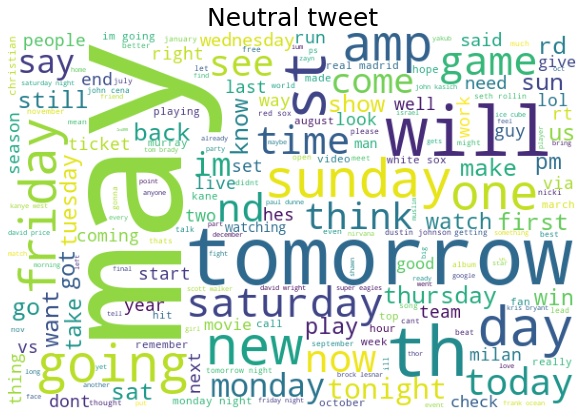

In [ ]:
plt.figure(figsize=(20,7))
wordcloud1 = WordCloud(background_color ='white',width=600, height= 400).generate(' '.join(neutral_df))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title('Neutral tweet',fontsize=25)

Text(0.5, 1.0, 'Positive tweet')

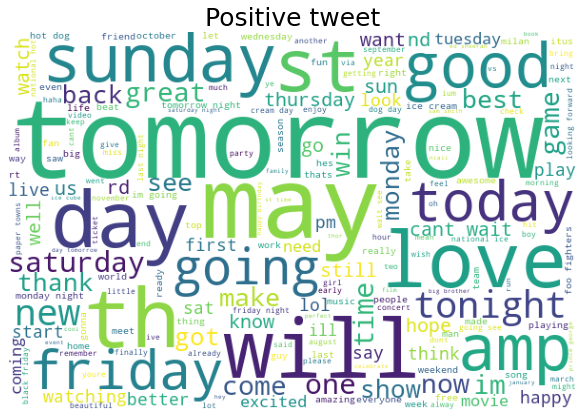

In [ ]:
plt.figure(figsize=(20,7))
wordcloud1 = WordCloud(background_color ='white',width=600, height= 400).generate(' '.join(positive_df))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title('Positive tweet',fontsize=25)

Text(0.5, 1.0, 'Negative tweet')

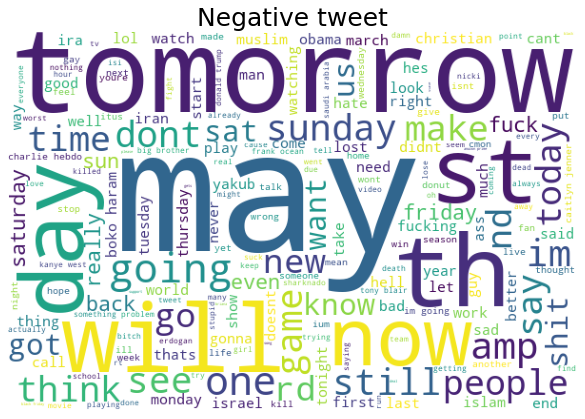

In [ ]:
plt.figure(figsize=(20,7))
wordcloud1 = WordCloud(background_color ='white',width=600, height= 400).generate(' '.join(negative_df..............................................))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title('Negative tweet',fontsize=25)

### Emotions

In [ ]:
joy_df = emotions_train.loc[emotions_train['Mapping']==1]['Processed_Text'] #joy tweets 
joy_df = joy_df.apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS])) # removing stopwords

In [ ]:
anger_df = emotions_train.loc[emotions_train['Mapping']==0]['Processed_Text'] #anger tweets 
anger_df = non_ironydf.apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS])) #removing stopwords

In [ ]:
optimism_df = emotions_train.loc[emotions_train['Mapping']==2]['Processed_Text'] #optimism tweets 
optimism_df = optimism_df.apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS])) #removing stopwords

In [ ]:
sadness_df = emotions_train.loc[emotions_train['Mapping']==3]['Processed_Text'] #sadness tweets 
sadness_df = sadness_df.apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS])) #removing stopwords

Text(0.5, 1.0, 'Joy tweet')

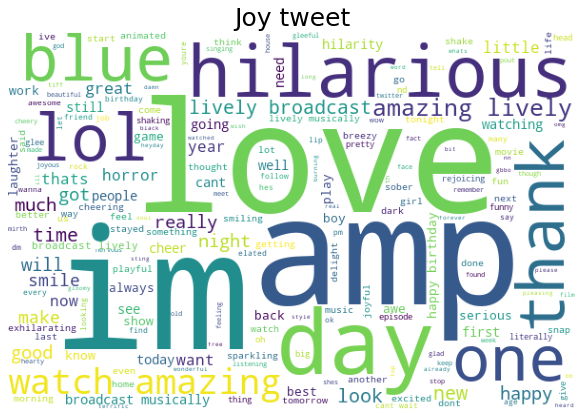

In [ ]:
plt.figure(figsize=(20,7))
wordcloud1 = WordCloud(background_color ='white',width=600, height= 400).generate(' '.join(joy_df))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title('Joy tweet',fontsize=25)

Text(0.5, 1.0, 'Angry tweet')

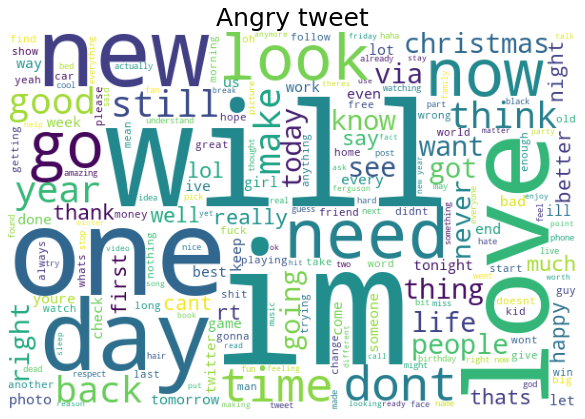

In [ ]:
plt.figure(figsize=(20,7))
wordcloud2 = WordCloud(background_color ='white',width =600, height =400).generate(' '.join(anger_df))
plt.imshow(wordcloud2)
plt.axis('off')
plt.title('Angry tweet',fontsize=25)

Text(0.5, 1.0, 'Optimistic tweet')

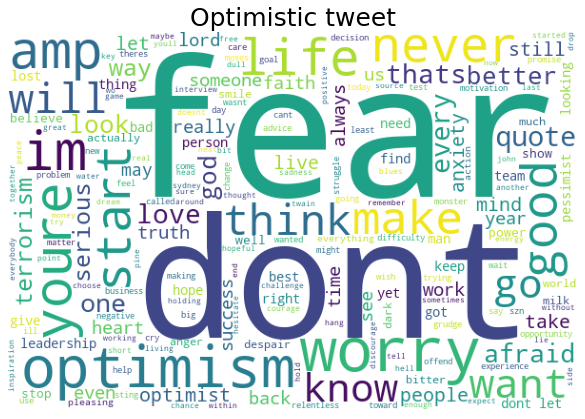

In [ ]:
plt.figure(figsize=(20,7))
wordcloud2 = WordCloud(background_color ='white',width =600, height =400).generate(' '.join(optimism_df))
plt.imshow(wordcloud2)
plt.axis('off')
plt.title('Optimistic tweet',fontsize=25)

Text(0.5, 1.0, 'Sad tweet')

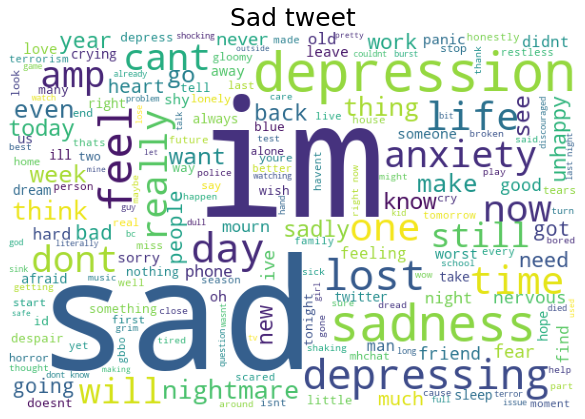

In [ ]:
plt.figure(figsize=(20,7))
wordcloud2 = WordCloud(background_color ='white',width =600, height =400).generate(' '.join(sadness_df))
plt.imshow(wordcloud2)
plt.axis('off')
plt.title('Sad tweet',fontsize=25)



---






### Irony 

In [ ]:
irony_df = irony_train.loc[irony_train['Mapping']==1]['Processed_Text'] #irony tweets 
irony_df = irony_df.apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS])) # removing stopwords

In [ ]:
non_ironydf = irony_train.loc[irony_train['Mapping']==0]['Processed_Text'] #non irony tweet
non_ironydf = non_ironydf.apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS])) #removing stopwords

Text(0.5, 1.0, 'Irony tweet')

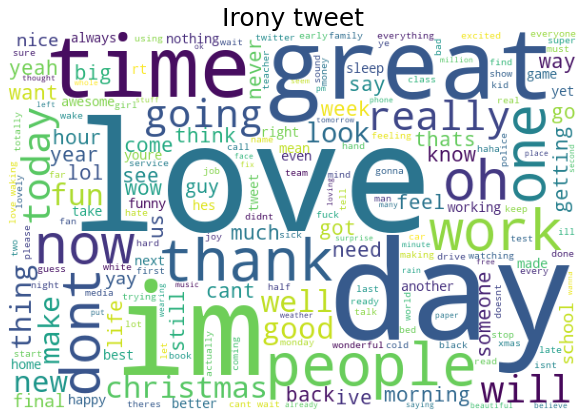

In [ ]:
plt.figure(figsize=(20,7))
wordcloud1 = WordCloud(background_color ='white',width=600, height= 400).generate(' '.join(irony_df))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title('Irony tweet',fontsize=25)

Text(0.5, 1.0, 'Non-irony tweet')

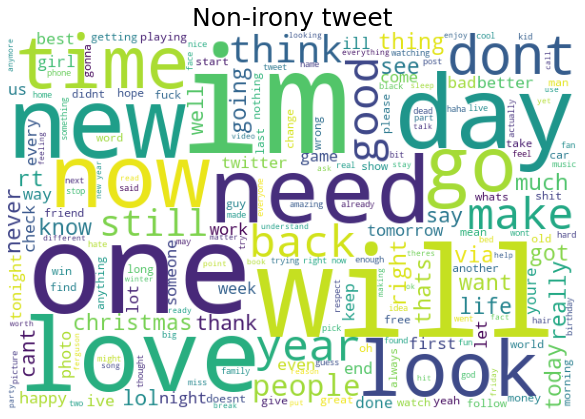

In [ ]:
plt.figure(figsize=(20,7))
wordcloud2 = WordCloud(background_color ='white',width =600, height =400).generate(' '.join(non_ironydf))
plt.imshow(wordcloud2)
plt.axis('off')
plt.title('Non-irony tweet',fontsize=25)



---






# Section 2

In this section, we will prepare text data for the BERT model. We will also focus on building our BERT model architecture and fine-tuning the model. Because we are working with three datasets, this section is divided into three to represent work done on the three datasets. 

# Model building.

# 2. 0 - Emotion prediction

## Baseline model 

For our baseline model, we used the TF-IDF to vectorize the text data, then we used th naive bayes model as our classifier. 

Data

In [10]:
data = pd.read_csv('/content/drive/MyDrive/datasets/preprocessedEmotionTrain.csv')

In [11]:
data = data[['Mapping','Processed_Text' ]]

In [12]:
from sklearn.model_selection import train_test_split

X = data.Processed_Text.values
y = data.Mapping.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.2, random_state=2020)

### Train Naive Bayes Classifier

#### Hyperparameter Tuning

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [8]:


def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

The `MultinominalNB` class only have one hypterparameter - **alpha**. The code below will help us find the alpha value that gives us the highest CV AUC score.

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

### Evaluation on Validation Set

In [15]:
labels = ['optimism ',	' anger',	'joy',	'sadness ']

In [18]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_val)

print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred,target_names=labels))

accuracy 0.558282208588957
              precision    recall  f1-score   support

   optimism        0.50      0.99      0.67       280
       anger       0.90      0.17      0.29       149
         joy       0.00      0.00      0.00        54
    sadness        0.87      0.36      0.50       169

    accuracy                           0.56       652
   macro avg       0.57      0.38      0.37       652
weighted avg       0.65      0.56      0.48       652

CPU times: user 25.1 ms, sys: 0 ns, total: 25.1 ms
Wall time: 26.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The naive bayes for text classification on our emotions dataset achieved an accuracy of 0.56. 

## Fine-tuning BERT

Import

In [56]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import random

Setting seed

In [57]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf
 
        tf.random.set_seed(seed)
 
set_seed(1542)

data

In [58]:
def read_ds(test_size=0.3):
  dataset = pd.read_csv('/content/drive/MyDrive/datasets/preprocessedEmotionTrain.csv')
  documents = dataset.Processed_Text.tolist()
  labels = dataset.Mapping.tolist()
  unique = dataset.Mapping.unique().tolist()
  # split into training & testing a return data as well as label names
  return train_test_split(documents, labels, test_size=test_size, stratify=labels), unique


In [59]:
dataset = pd.read_csv('/content/drive/MyDrive/datasets/preprocessedEmotionTrain.csv')

## 2.0.1 -  Building the BERT classifier

In [63]:
model_name = "bert-base-uncased"
# setting maximum length. 
max_length = 250

In [65]:
# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

In [66]:
# call the function
(train_texts, valid_texts, train_labels, valid_labels), target_names = read_ds()

In [67]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [68]:
#encoding train and test data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

In [69]:
class EmotionsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = EmotionsDataset(train_encodings, train_labels)
valid_dataset = EmotionsDataset(valid_encodings, valid_labels)

In [70]:
# load the model and pass to CUDA
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names)).to("cuda")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [71]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

## 2.0.2 - Training model on dataset 

We will train our Bert Classifier for 10 epochs. In each epoch, we will train our model and evaluate its performance on the test set. 

In [76]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=128,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    logging_steps=200,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [77]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [78]:
# train the model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
200,0.467100,0.712836,0.766871,1.178500,829.856000


TrainOutput(global_step=360, training_loss=0.30549126201205784, metrics={'train_runtime': 143.4678, 'train_samples_per_second': 2.509, 'total_flos': 613811906503440.0, 'epoch': 10.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 4661248, 'train_mem_gpu_alloc_delta': 1327660032, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 1420242432})

## 2.0.3 - Evaluating model

In [79]:
# evaluate the current model after training
trainer.evaluate()

{'epoch': 10.0,
 'eval_accuracy': 0.7668711656441718,
 'eval_loss': 0.712835967540741,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 176330752,
 'eval_runtime': 1.1965,
 'eval_samples_per_second': 817.394}

In [ ]:
# saving the fine tuned model & tokenizer
model_path = "emotion-bert-base-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('emotion-bert-base-uncased/tokenizer_config.json',
 'emotion-bert-base-uncased/special_tokens_map.json',
 'emotion-bert-base-uncased/vocab.txt',
 'emotion-bert-base-uncased/added_tokens.json')

The Bert Classifer achieves 76.68% accuracy rate on the validation set. This is higher than our baseline model.

## 2.0.4 - Prediciting on test set

In [ ]:
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    return target_names[probs.argmax()]

In [ ]:
# Example #2
text = """
this overcast cloudy rainy weather makes me lazy glum and sad
"""
print(get_prediction(text))

3


# 2. 1 - Building the classifier for Sentiment prediction 

## Baseline model 

We use the same process we used for Emotions predicition for this section (baseline model) 

Data

In [19]:
data = pd.read_csv('/content/drive/MyDrive/datasets/preprocessedSentimentTrain.csv')

In [20]:
data = data[['Mapping','Processed_Text' ]]

In [21]:
from sklearn.model_selection import train_test_split

X = data.Processed_Text.values
y = data.Mapping.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.2, random_state=2020)

### Train Naive Bayes Classifier

#### Hyperparameter Tuning

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

### Evaluation on Validation Set

In [23]:
labels = ['positive', 'neutral',  'negative']

In [24]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_val)

print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred,target_names=labels))

accuracy 0.6108736161350433
              precision    recall  f1-score   support

    positive       0.64      0.00      0.01      1425
     neutral       0.58      0.79      0.67      4135
    negative       0.67      0.64      0.65      3563

    accuracy                           0.61      9123
   macro avg       0.63      0.48      0.44      9123
weighted avg       0.62      0.61      0.56      9123

CPU times: user 205 ms, sys: 939 µs, total: 206 ms
Wall time: 205 ms


Out naive bayes model goves us an accuracy of 61% on test set. 

## Fine-tuning BERT

Setting seed

In [ ]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf
 
        tf.random.set_seed(seed)
 
set_seed(1500)

data

In [93]:
def read_ds(test_size=0.3):
  dataset = pd.read_csv('/content/drive/MyDrive/datasets/preprocessedSentimentTrain.csv')
  documents = dataset.Processed_Text.tolist()
  labels = dataset.Mapping.tolist()
  unique = dataset.Mapping.unique().tolist()
  # split into training & testing a return data as well as label names
  return train_test_split(documents, labels, test_size=test_size), unique
  


In [94]:
dataset = pd.read_csv('/content/drive/MyDrive/datasets/preprocessedSentimentTrain.csv')

## 2.1.1 -  Building the BERT classifier

In [95]:
model_name = "bert-base-uncased"
# setting maximum length. 
max_length = 250

In [96]:
# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

In [97]:
# call the function
(train_texts, valid_texts, train_labels, valid_labels), target_names = read_ds()

In [98]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [99]:
#encoding train and test data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

In [100]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = SentimentDataset(train_encodings, train_labels)
valid_dataset = SentimentDataset(valid_encodings, valid_labels)

In [101]:
# load the model and pass to CUDA
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names)).to("cuda")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [102]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

## 2.1.2 - Training model on dataset 

In [103]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=128,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [104]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [105]:
# train the model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
200,0.931500,0.707090,0.681915,19.726400,693.742000
400,0.696400,0.663159,0.701133,19.762700,692.465000
600,0.624400,0.729153,0.687541,19.766400,692.337000
800,0.568600,0.643345,0.710047,19.761900,692.495000
1000,0.568900,0.671539,0.719474,19.757900,692.634000
1200,0.347900,0.854111,0.704713,19.740100,693.258000
1400,0.348100,0.754185,0.704056,19.771500,692.159000
1600,0.263500,1.035050,0.705298,19.768900,692.249000
1800,0.185400,0.976923,0.710997,19.752900,692.811000
2000,0.186100,0.980807,0.709317,19.761500,692.509000


TrainOutput(global_step=4990, training_loss=0.21726476448571275, metrics={'train_runtime': 3742.3286, 'train_samples_per_second': 1.333, 'total_flos': 9648522776559600.0, 'epoch': 10.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -34574336, 'train_mem_gpu_alloc_delta': 1776121856, 'train_mem_cpu_peaked_delta': 34848768, 'train_mem_gpu_peaked_delta': 1701166080})

## 2.1.3 - Evaluating model

In [106]:
# evaluate the current model after training
trainer.evaluate()

{'epoch': 10.0,
 'eval_accuracy': 0.7100474972597735,
 'eval_loss': 0.6433447599411011,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 339309568,
 'eval_runtime': 19.7542,
 'eval_samples_per_second': 692.764}

In [ ]:
# saving the fine tuned model & tokenizer
model_path = "sentiment-bert-base-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('sentiment-bert-base-uncased/tokenizer_config.json',
 'sentiment-bert-base-uncased/special_tokens_map.json',
 'sentiment-bert-base-uncased/vocab.txt',
 'sentiment-bert-base-uncased/added_tokens.json')

The Bert Classifer achieves 71% accuracy rate on the validation set.

# 2. 2 - Irony prediction  

## Baseline model 

For our baseline model, we used the TF-IDF to vectorize the text data, then we used th naive bayes model as our classifier. 

Data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/datasets/preprocessedIronyTrain.csv')

In [ ]:
data = data[['Mapping','Processed_Text' ]]

In [ ]:
from sklearn.model_selection import train_test_split

X = data.Processed_Text.values
y = data.Mapping.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.2, random_state=2020)

### TF-IDF Vectorizer

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer


# Preprocess text
X_train = np.array(X_train)
X_val = np.array( X_val)

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train)
X_val_tfidf = tf_idf.transform(X_val)

CPU times: user 277 ms, sys: 7.04 ms, total: 284 ms
Wall time: 283 ms


### Train Naive Bayes Classifier

#### Hyperparameter Tuning

We will use cross-validation and AUC score to tune hyperparameters of our model. The function `get_auc_CV` will return the average AUC score from cross-validation.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

The `MultinominalNB` class only have one hypterparameter - **alpha**. The code below will help us find the alpha value that gives us the highest CV AUC score.

Best alpha:  9.3


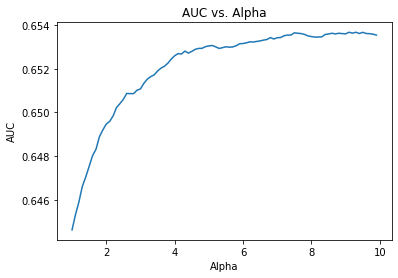

In [ ]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

#### Evaluation on Validation Set

To evaluate the performance of our model, we will calculate the accuracy rate and the AUC score of our model on the validation set.

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

By combining TF-IDF and the Naive Bayes algorithm, we achieve the accuracy rate of 61.43% on the test set. This value is the baseline performance and will be used to evaluate the performance of our fine-tune BERT model. 

AUC: 0.6938
Accuracy: 61.43%


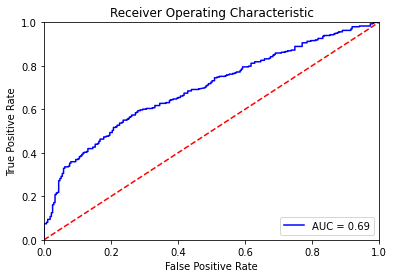

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

##BERT Modelling

Imports

In [ ]:
import torch.nn as nn
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel

# specify GPU
device = torch.device("cuda")


Load Dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/datasets/preprocessedIronyTrain.csv")
df.head()

,Unnamed: 0,text,Mapping,word_count,unique_wordcount,mean_word_length,tweet_length,url_count,hashtags,mention_count,stopwords,punctuation_count,text_Adjectives,Processed_Text
0,0,seeing ppl walking w/ crutches makes me really...,1,17,17,4.12,86,0,0,0,5,1,w/ next,seeing ppl walking w crutches makes me really ...
1,1,"look for the girl with the broken smile, ask h...",0,22,20,3.68,102,0,0,0,11,3,NaN,look for the girl with the broken smile ask he...
2,2,Now I remember why I buy books online @user #s...,1,10,9,5.30,62,0,1,1,3,2,NaN,now i remember why i buy books online service...
3,3,@user @user So is he banded from wearing the c...,1,11,10,4.55,61,0,1,1,5,4,NaN,so is he banded from wearing the clothes karma
4,4,Just found out there are Etch A Sketch apps. ...,1,11,11,5.36,70,0,1,0,5,3,oldschool,just found out there are etch a sketch apps o...


In [ ]:
df.shape

(2862, 14)

In [ ]:
# check class distribution
df['Mapping'].value_counts(normalize = True)

1    0.504892
0    0.495108
Name: Mapping, dtype: float64

In [ ]:
df = df[['Mapping','Processed_Text']]

In [ ]:
df.head()

,Mapping,Processed_Text
0,1,seeing ppl walking w crutches makes me really ...
1,0,look for the girl with the broken smile ask he...
2,1,now i remember why i buy books online service...
3,1,so is he banded from wearing the clothes karma
4,1,just found out there are etch a sketch apps o...


## Split train dataset into train, validation and test sets

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['Processed_Text'], df['Mapping'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Mapping'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.3, 
                                                                stratify=temp_labels)

## Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


## Tokenization

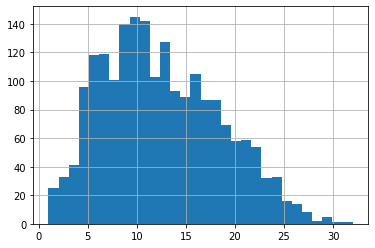

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 125

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    padding = True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    padding = True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    padding = True,
    truncation=True,
    return_token_type_ids=False
)

## Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

## Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 125

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

## Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 

      
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict = False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 2e-5)

## Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.57743559 3.72848948]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

## Fine-Tune BERT

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

## Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.238
Validation Loss: 0.360

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.223
Validation Loss: 0.175

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.173
Validation Loss: 0.123

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.224
Validation Loss: 0.491

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.218
Validation Loss: 0.131

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.168
Validation Loss: 0.128

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.173
Validation Loss: 0.322

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.279
Validat

## Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Get Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       724
           1       0.82      0.95      0.88       112

    accuracy                           0.97       836
   macro avg       0.91      0.96      0.93       836
weighted avg       0.97      0.97      0.97       836



The accuracy from our fine-tuned model is 97%, which is far greater than that from our baseline model(61.43%)

In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,701,23
1,6,106
